# Imports and Functions

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import validation_curve
import statsmodels.api as sm
import math
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from scipy import stats
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

In [145]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

In [47]:
df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df = df[df.schedule_season > 1978]

In [48]:
df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

In [49]:
df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

In [50]:
df = df.fillna(value = 0)

In [51]:
df.index = range(0, len(df))

In [52]:
reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 19) & (df.schedule_season>2001)]

In [53]:
spread_samples = np.random.choice(week5_df.spread_favorite,25)
sample_means = spread_samples.mean()

def n_samples(arr,sample_size,n_samples):
    size = sample_size
    sample_means=[]
    
    for n in range(n_samples):
        sample_means.append(np.random.choice(arr,size).mean())
    
    return sample_means

x = n_samples(week5_df.spread_favorite,25,1000)

#sns.distplot(x)

# ax1 = n_samples(week5_df.spread_favorite[(week5_df.spread_favorite>-12.5) & (week5_df.home_favorite==1)],100,5000)
# ax2 = n_samples(week5_df.spread_favorite[(week5_df.spread_favorite>-12.5) & (week5_df.home_favorite==0)],100,5000)
# sns.distplot(ax1)
# sns.distplot(ax2)
# sum(week5_df.spread_favorite<-12.5)/len(week5_df)
# np.sum(ax1)/len(ax1)
# np.sum(ax2)/len(ax2)

In [94]:
reg_df.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,weather_detail,weather_temperature,weather_wind_mph,weather_humidity,score_home,score_away,point_total,over_under_result,score_difference,home_id,away_id,home_favorite,favorite_covered,winning_team,losing_team,home_wins,home_losses,home_ties,away_wins,away_losses,away_ties,home_points_for,home_points_against,away_points_for,away_points_against,h_games,a_games,home_win_pct,away_win_pct,win_pct_diff,h_ppg,h_papg,a_ppg,a_papg,home_pt_diff_pg,away_pt_diff_pg,pt_diff_pg,home_exp_win_pct,away_exp_win_pct,home_win_pct_last_4,away_win_pct_last_4,exp_win_difference,total_ppg,total_points_against,last_four_difference
5387,09/15/2002,2002,2,Atlanta Falcons,Chicago Bears,ATL,-2.5,45.0,DOME,72.0,0.0,66.552,13,14,27,under,-1,ATL,CHI,1,0,CHI,ATL,0,1,0,1,0,0,34,37,27,23,1,1,0.0,1.0,-1.0,34.0,37.0,27.0,23.0,-3.0,4.0,-7.0,0.368063,0.719232,0.00,0.25,-0.351169,61.0,60.0,-0.25
5388,09/15/2002,2002,2,Baltimore Ravens,Tampa Bay Buccaneers,TB,-4.5,32.0,0,73.0,8.0,94.000,0,25,25,under,-25,BAL,TB,0,0,TB,BAL,0,1,0,0,1,0,7,10,20,26,1,1,0.0,0.0,0.0,7.0,10.0,20.0,26.0,-3.0,-6.0,3.0,0.180159,0.181480,0.00,0.00,-0.001321,27.0,36.0,0.00
5389,09/15/2002,2002,2,Carolina Panthers,Detroit Lions,CAR,-3.0,35.5,0,70.0,10.0,98.000,31,7,38,over,24,CAR,DET,1,1,CAR,DET,1,0,0,0,1,0,10,7,21,49,1,1,1.0,0.0,1.0,10.0,7.0,21.0,49.0,3.0,-28.0,31.0,0.819841,0.004504,0.25,0.00,0.815337,31.0,56.0,0.25
5390,09/15/2002,2002,2,Cleveland Browns,Cincinnati Bengals,CLE,-3.5,39.0,0,72.0,10.0,92.000,20,7,27,under,13,CLE,CIN,1,1,CLE,CIN,0,1,0,0,1,0,39,40,6,34,1,1,0.0,0.0,0.0,39.0,40.0,6.0,34.0,-1.0,-28.0,27.0,0.458620,0.000068,0.00,0.00,0.458552,45.0,74.0,0.00
5391,09/15/2002,2002,2,Dallas Cowboys,Tennessee Titans,TEN,-3.5,37.5,0,79.0,12.0,62.000,21,13,34,under,8,DAL,TEN,0,0,DAL,TEN,0,1,0,1,0,0,10,19,27,24,1,1,0.0,1.0,-1.0,10.0,19.0,27.0,24.0,-9.0,3.0,-12.0,0.037651,0.666962,0.00,0.25,-0.629311,37.0,43.0,-0.25


In [110]:
o_u_pivot = reg_df.pivot_table(index='over_under_line', columns='over_under_result',
                    aggfunc={'over_under_result':len}, fill_value = 0)

In [111]:
o_u_pivot['row_total'] = 0
for index, row in o_u_pivot.iterrows():
    row.row_total = sum(row)

In [120]:
ou_covered = o_u_pivot.over_under_result['over']
ou_no_cover = o_u_pivot.over_under_result['under']
ou_push = o_u_pivot.over_under_result['push']

In [140]:
lines = sorted(set(reg_df.over_under_line))
x_lines = np.array([spread for spread in lines if spread > 33 and spread < 56])

In [141]:
pivot = reg_df.pivot_table(index='spread_favorite', columns='favorite_covered',
                    aggfunc={'favorite_covered':len}, fill_value = 0)

In [142]:
y_over = [ou_covered[value]/o_u_pivot['row_total'][value] for value in x_lines]
y_under = [ou_no_cover[value]/o_u_pivot['row_total'][value] for value in x_lines]
y_neither = [ou_push[value]/o_u_pivot['row_total'][value] for value in x_lines]

In [55]:
pivot['row_total'] = 0
for index, row in pivot.iterrows():
    row.row_total = sum(row)

In [56]:
covered = pivot.favorite_covered[1]
no_cover = pivot.favorite_covered[0]
push = pivot.favorite_covered[2]

In [57]:
spreads = sorted(set(reg_df.spread_favorite))
x = np.array([spread for spread in spreads if spread > -15 and spread < 0])

In [58]:
y_covered = [covered[value]/pivot['row_total'][value] for value in x]
y_no_cover = [no_cover[value]/pivot['row_total'][value] for value in x]
y_push = [push[value]/pivot['row_total'][value] for value in x]

In [59]:
heat_o_u = reg_df[['over_under_line','weather_wind_mph', 'weather_humidity', 'total_points_against', 'total_ppg','weather_temperature']]
corr_o_u = heat_o_u.corr()
heat_spread = reg_df[['spread_favorite','exp_win_difference', 'home_favorite', 'total_points_against', 'total_ppg','weather_temperature']]
corr_spread = heat_spread.corr()

In [60]:
def poly_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max,xfit1, xfit2, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
#     split = train_test_split(x, y)
#     X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
#     x = X_train
#     y = y_train
#     plt.scatter(x, y, s = s, alpha = alpha)
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']=='over']
        y2 = y[reg_df['over_under_result']=='under']
        x1 = x[reg_df['over_under_result']=='over']
        x2 = x[reg_df['over_under_result']=='under']
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xfit1,xfit2, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [61]:
def regression_evaluation(target, X_list):
    target = target
    X = X_list 
    X2 = sm.add_constant(X)
    # model = sm.ols(formula = 'over_under_line ~ np.power(total_points_against, 1)', data = reg_df).fit()

    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted
    
    plt.scatter(y_predicted,residuals)
    check = round(rmse_check(y_predicted, y_actual) - rmse)
    print(est2.summary())
    plt.scatter(y_predicted,residuals)
    
    print('RMSE=' + str(rmse) + ', check =' + str(check))

In [62]:
def rmse_check(predictions, targets):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val                                           #get the ^

In [87]:
def log_linear_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max,xfit1, xfit2, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x, np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']=='over']
        y2 = y[reg_df['over_under_result']=='under']
        x1 = x[reg_df['over_under_result']=='over']
        x2 = x[reg_df['over_under_result']=='under']
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xfit1,xfit2, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [64]:
def log_log_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max,xfit1, xfit2, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(np.log(x+1), np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']=='over']
        y2 = y[reg_df['over_under_result']=='under']
        x1 = x[reg_df['over_under_result']=='over']
        x2 = x[reg_df['over_under_result']=='under']
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xfit1,xfit2, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [93]:
test_df = week5_df[week5_df.schedule_season>2010]


# Distributions

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-10, 0)

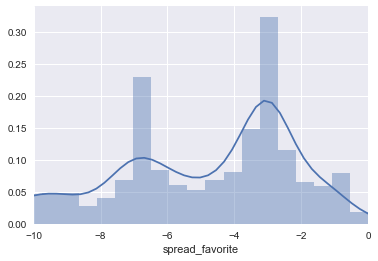

In [43]:
rw5 = np.random.choice(week5_df.spread_favorite,10)

ax = sns.distplot(week5_df.spread_favorite)
ax.set_xlim(-10,0)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


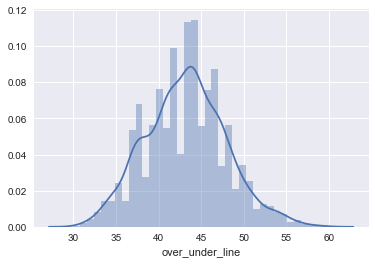

In [44]:
sns.distplot(reg_df.over_under_line)

# Spread Summaries

In [143]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=x_lines,
    y=y_over,
    name='Over'
)
trace2 = go.Bar(
    x=x_lines,
    y=y_under,
    name='Under'
)

trace3 = go.Bar(
    x=x_lines,
    y=y_neither,
    name='Push'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

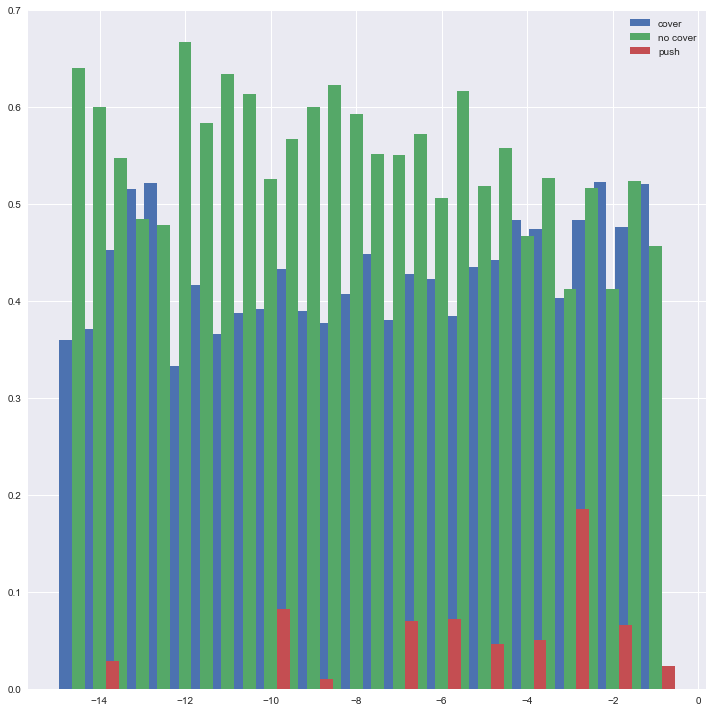

In [22]:
plt.figure(figsize = (10,10))
plt.bar(x-.3,y_covered, label = 'cover', width = .3)
plt.bar(x,y_no_cover, label = 'no cover', width = .3)
plt.bar(x+.3,y_push, label = 'push', width = .3)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=x,
    y=y_covered,
    name='Covered'
)
trace2 = go.Bar(
    x=x,
    y=y_no_cover,
    name='No Cover'
)

trace3 = go.Bar(
    x=x,
    y=y_push,
    name='Push'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

# Correlation Heatmaps

,over_under_line,weather_wind_mph,weather_humidity,total_points_against,total_ppg,weather_temperature
over_under_line,1.000000,-0.278144,-0.072963,0.358626,0.601954,0.161149
weather_wind_mph,-0.278144,1.000000,0.007393,-0.092258,-0.081021,-0.369755
weather_humidity,-0.072963,0.007393,1.000000,-0.017911,-0.041513,-0.059259
total_points_against,0.358626,-0.092258,-0.017911,1.000000,-0.036109,0.043556
total_ppg,0.601954,-0.081021,-0.041513,-0.036109,1.000000,-0.025085
weather_temperature,0.161149,-0.369755,-0.059259,0.043556,-0.025085,1.000000


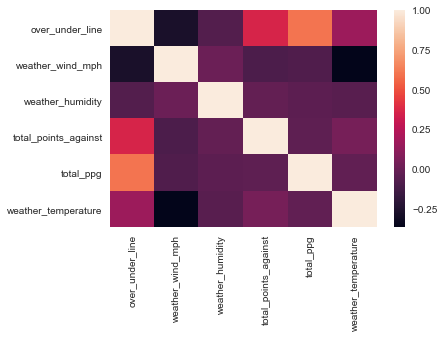

In [39]:
sns.heatmap(corr_o_u,xticklabels=corr_o_u.columns,
        yticklabels=corr_o_u.columns)
display(corr_o_u)

,spread_favorite,exp_win_difference,home_favorite,total_points_against,total_ppg,weather_temperature
spread_favorite,1.000000,-0.368167,-0.195108,-0.031186,0.030883,0.072987
exp_win_difference,-0.368167,1.000000,0.524128,-0.001068,-0.007244,-0.075372
home_favorite,-0.195108,0.524128,1.000000,-0.035127,-0.034868,-0.043117
total_points_against,-0.031186,-0.001068,-0.035127,1.000000,-0.036109,0.043556
total_ppg,0.030883,-0.007244,-0.034868,-0.036109,1.000000,-0.025085
weather_temperature,0.072987,-0.075372,-0.043117,0.043556,-0.025085,1.000000


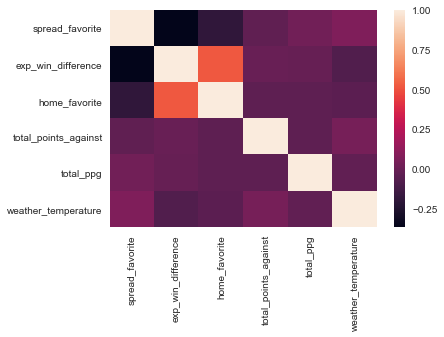

In [38]:
sns.heatmap(corr_spread,xticklabels=corr_spread.columns,
        yticklabels=corr_spread.columns)
display(corr_spread)

# LINEAR REGRESSIONS

# OVER/UNDER

# Variable 1 -Total Points Against

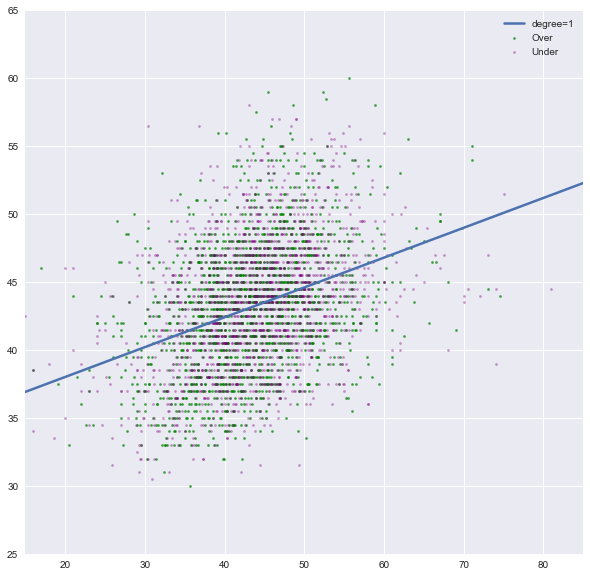

In [30]:
poly_regression((reg_df.total_points_against), reg_df.over_under_line, [1],15,85, 25, 65,10,150)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     566.6
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          6.17e-117
Time:                        10:23:18   Log-Likelihood:                -11140.
No. Observations:                3841   AIC:                         2.228e+04
Df Residuals:                    3839   BIC:                         2.230e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   33.6210 

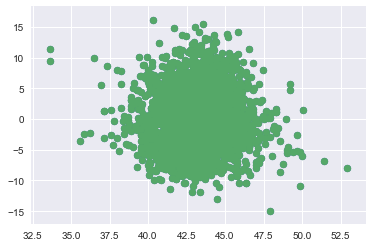

In [31]:
regression_evaluation(reg_df.over_under_line, reg_df.total_points_against)

# VARIABLE 2 -TOTAL PPG

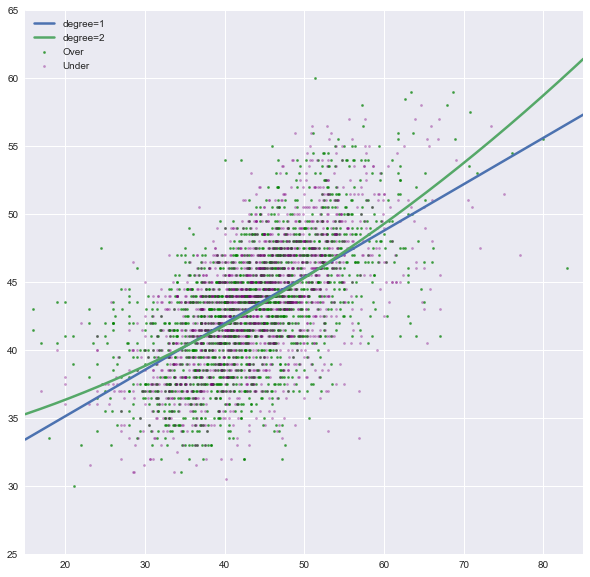

In [32]:
poly_regression((reg_df.total_ppg), reg_df.over_under_line, [1,2],15,85, 25, 65,10,150)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     2182.
Date:                Mon, 13 Aug 2018   Prob (F-statistic):               0.00
Time:                        10:23:19   Log-Likelihood:                -10540.
No. Observations:                3841   AIC:                         2.108e+04
Df Residuals:                    3839   BIC:                         2.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.2891      0.325     87.052      0.0

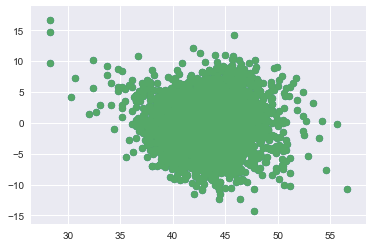

In [33]:
regression_evaluation(reg_df.over_under_line, (reg_df.total_ppg**1))

## VARIABLE 3 -WEATHER HUMIDITY

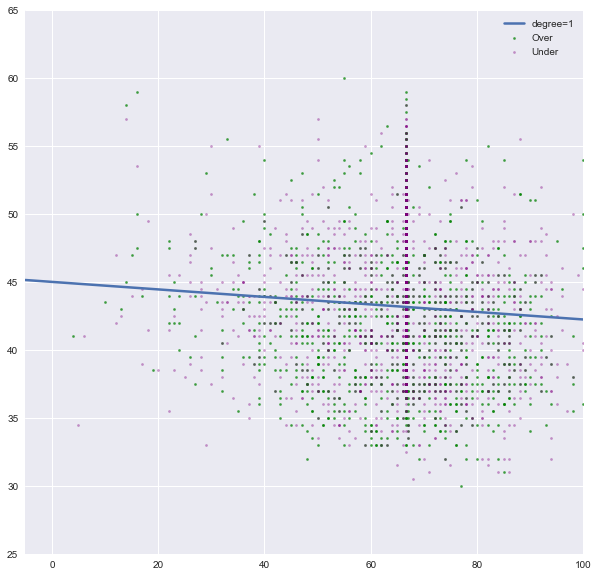

In [34]:
poly_regression(reg_df.weather_humidity, reg_df.over_under_line, [1],-5,100, 25, 65,-15,150)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     20.55
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           6.00e-06
Time:                        10:23:23   Log-Likelihood:                -11394.
No. Observations:                3841   AIC:                         2.279e+04
Df Residuals:                    3839   BIC:                         2.281e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               45.0086      0.406  

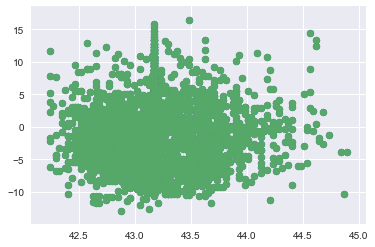

In [35]:
regression_evaluation(reg_df.over_under_line, (reg_df.weather_humidity**1))

# VARIABLE 4 - WIND MPH

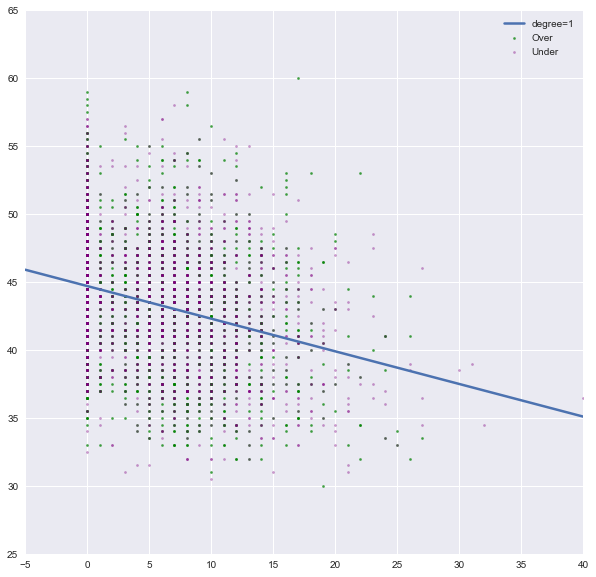

In [36]:
poly_regression(reg_df.weather_wind_mph, reg_df.over_under_line, [1],-5,40, 25, 65,-10,60)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     321.9
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           3.47e-69
Time:                        10:23:26   Log-Likelihood:                -11250.
No. Observations:                3841   AIC:                         2.250e+04
Df Residuals:                    3839   BIC:                         2.252e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               44.7007      0.111  

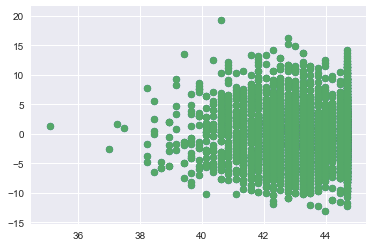

In [37]:
regression_evaluation(reg_df.over_under_line, (reg_df.weather_wind_mph**1))

# VARIABLE 5 - Weather Temp

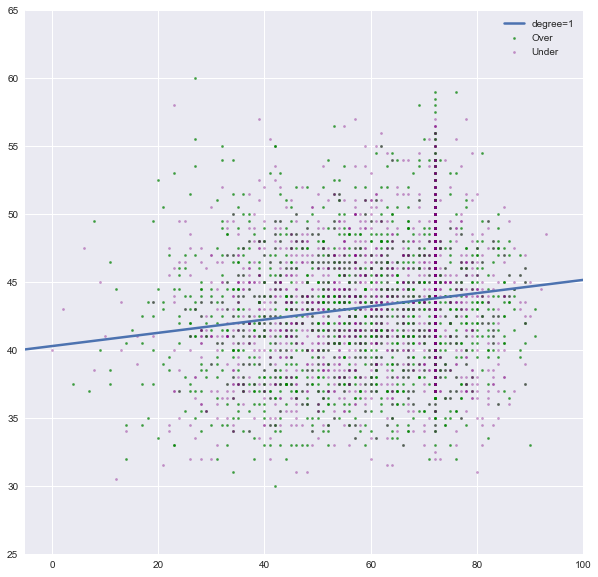

In [38]:
poly_regression(reg_df.weather_temperature, reg_df.over_under_line, [1],-5,100, 25, 65,-10,110)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     102.4
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           9.20e-24
Time:                        10:23:28   Log-Likelihood:                -11354.
No. Observations:                3841   AIC:                         2.271e+04
Df Residuals:                    3839   BIC:                         2.272e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  40.2849    

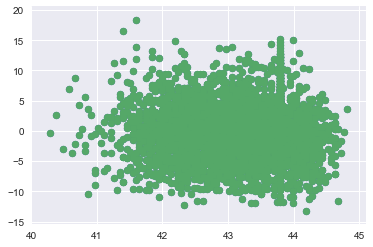

In [39]:
regression_evaluation(reg_df.over_under_line, (reg_df.weather_temperature**1))

# ALL VARIABLES FOR OVER/UNDER

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     957.6
Date:                Mon, 13 Aug 2018   Prob (F-statistic):               0.00
Time:                        10:23:30   Log-Likelihood:                -9848.5
No. Observations:                3841   AIC:                         1.971e+04
Df Residuals:                    3835   BIC:                         1.975e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.5255      0.570     32.486      0.0

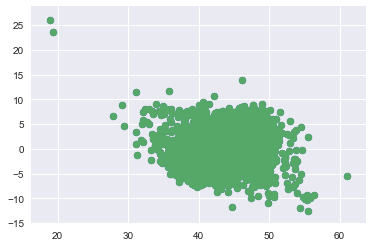

In [40]:
regression_evaluation(reg_df.over_under_line, reg_df[['weather_wind_mph', 'weather_humidity', 'total_points_against', 'total_ppg','weather_temperature']].values)

# SPREAD 

# Last 4 Games win %

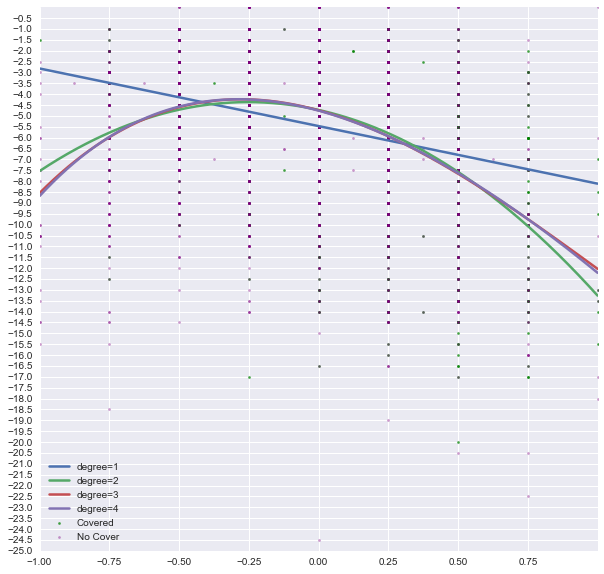

In [41]:
poly_regression(reg_df.last_four_difference, reg_df.spread_favorite, [1,2,3,4],-1,1, -25, 0,-1,1)
plt.yticks(np.arange(-25,0,.5))
plt.xticks(np.arange(-1,1,.25));

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     326.0
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           5.11e-70
Time:                        10:23:35   Log-Likelihood:                -10023.
No. Observations:                3841   AIC:                         2.005e+04
Df Residuals:                    3839   BIC:                         2.006e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -5.4669 

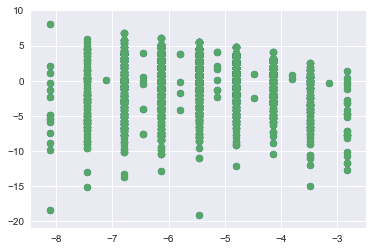

In [42]:
regression_evaluation(reg_df.spread_favorite, (reg_df.last_four_difference**1))

# WIN % DIFF REJECTED DUE TO LOW HIGH CORRELATION WITH EXP WINS

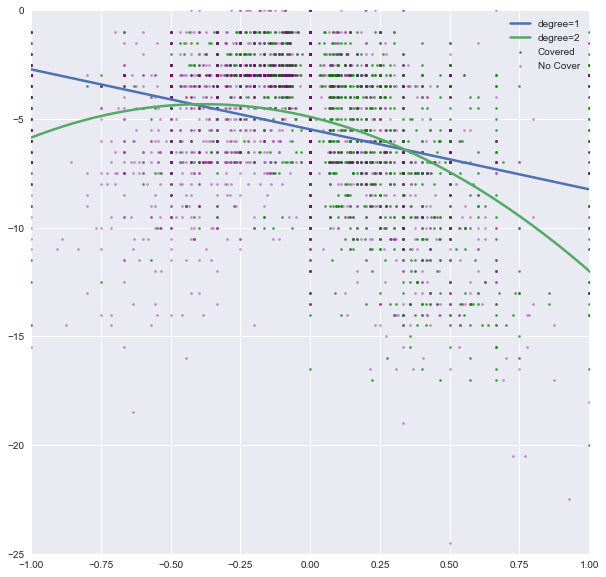

In [43]:
poly_regression(reg_df.win_pct_diff, reg_df.spread_favorite, [1,2],-1,1, -25, 0,-1,1)

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     394.6
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           1.17e-83
Time:                        10:23:37   Log-Likelihood:                -9991.7
No. Observations:                3841   AIC:                         1.999e+04
Df Residuals:                    3839   BIC:                         2.000e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.4802      0.053   -103.916   

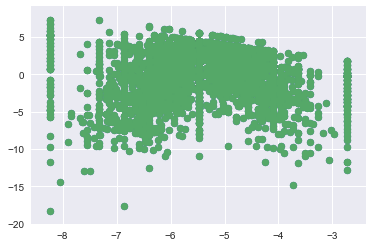

In [44]:
regression_evaluation(reg_df.spread_favorite, (reg_df.win_pct_diff**1))

# First Variable- Home Favorite

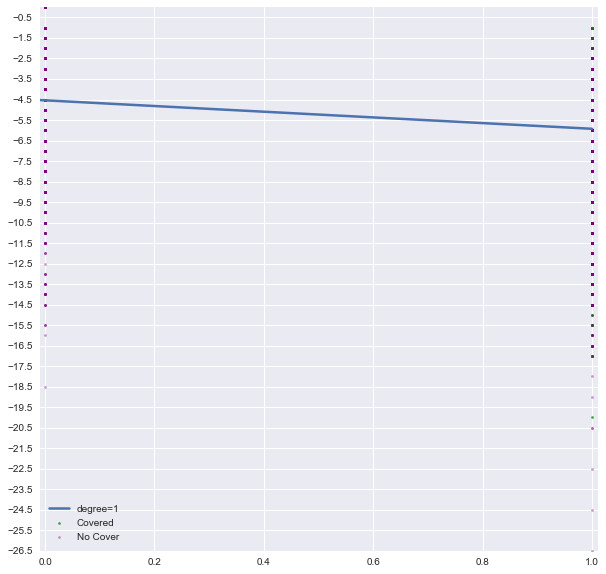

In [45]:
poly_regression(reg_df.home_favorite, reg_df.spread_favorite, [1],-.01,1.01, -25, 0,-1,1)
plt.yticks(np.arange(-26.5,0,1));

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     151.9
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           2.90e-34
Time:                        10:23:40   Log-Likelihood:                -10105.
No. Observations:                3841   AIC:                         2.021e+04
Df Residuals:                    3839   BIC:                         2.023e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.5399      0.090    -50.634

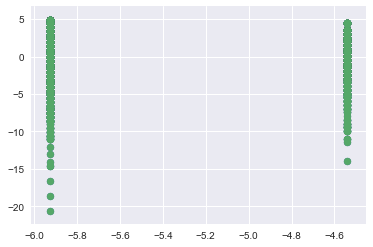

In [46]:
regression_evaluation(reg_df.spread_favorite, (reg_df.home_favorite**1))

In [47]:
# data = {"a":[2, 3, 5], "b":[2, 3, 5], "c":[2, 3, 5]}
# model = sm.ols(formula = 'a ~ np.power(b, 2) + b + c', data = reg_df).fit()

# SECOND VARIABLE - Exp Win Difference

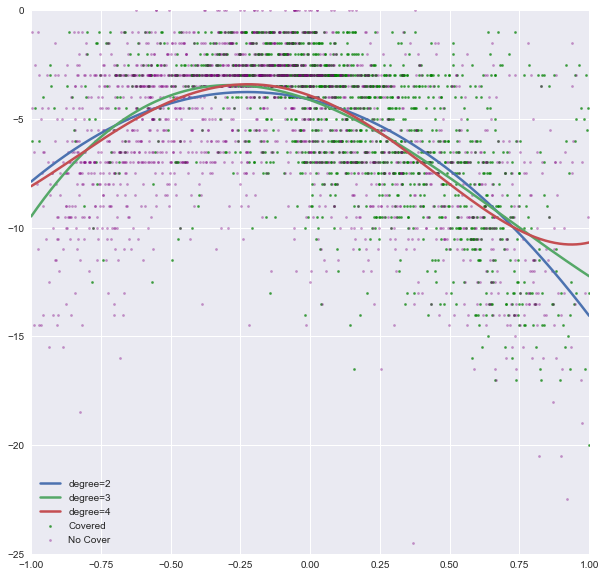

In [48]:
poly_regression(reg_df.exp_win_difference, reg_df.spread_favorite, [2,3,4],-1,1, -25, 0,-1,1)

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     897.4
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          2.22e-177
Time:                        10:23:44   Log-Likelihood:                -9776.1
No. Observations:                3841   AIC:                         1.956e+04
Df Residuals:                    3839   BIC:                         1.957e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.1326      0

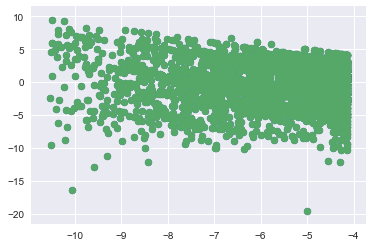

In [49]:
regression_evaluation(reg_df.spread_favorite, (reg_df.exp_win_difference**2))

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     255.6
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          3.12e-151
Time:                        10:23:45   Log-Likelihood:                -9829.7
No. Observations:                3841   AIC:                         1.967e+04
Df Residuals:                    3837   BIC:                         1.969e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0249      0.069    -87.557      0.0

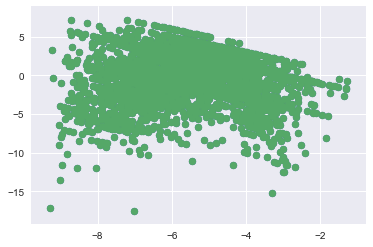

In [50]:
regression_evaluation(reg_df.spread_favorite, reg_df[['last_four_difference', 'exp_win_difference', 'favorite_covered']].values)

# WEEK- REJECTED LOW PREDICTABILITY

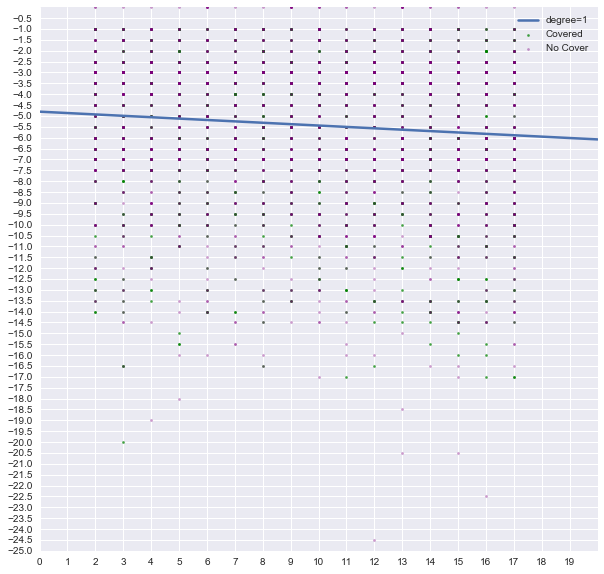

In [51]:
poly_regression(reg_df.schedule_week, reg_df.spread_favorite, [1],0,20, -25, 0,0,25)
plt.yticks(np.arange(-25,0,.5))
plt.xticks(np.arange(0,20,1));

# LOG REGRESSIONS

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     376.7
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          2.00e-199
Time:                        11:11:13   Log-Likelihood:                -1422.3
No. Observations:                2332   AIC:                             2853.
Df Residuals:                    2328   BIC:                             2876.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0110 

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


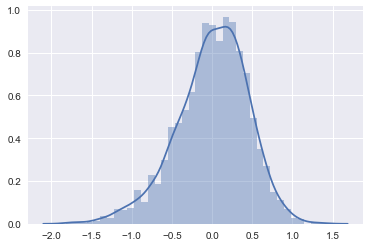

In [88]:
log_log_regression_evaluation(week5_df.spread_favorite, week5_df[['home_favorite', 'exp_win_difference','last_four_difference']])

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     1052.
Date:                Mon, 13 Aug 2018   Prob (F-statistic):               0.00
Time:                        11:11:14   Log-Likelihood:                 3257.6
No. Observations:                2332   AIC:                            -6503.
Df Residuals:                    2326   BIC:                            -6469.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.7554 

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


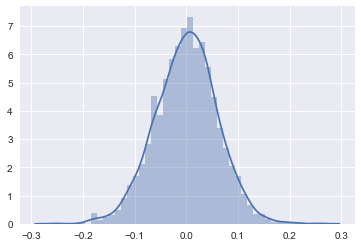

In [89]:
log_log_regression_evaluation(week5_df.over_under_line, week5_df[['weather_temperature', 'weather_wind_mph','weather_humidity', 'total_ppg', 'total_points_against']])

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     525.3
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          6.45e-107
Time:                        11:05:26   Log-Likelihood:                -2051.1
No. Observations:                2880   AIC:                             4106.
Df Residuals:                    2878   BIC:                             4118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.3953      0

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


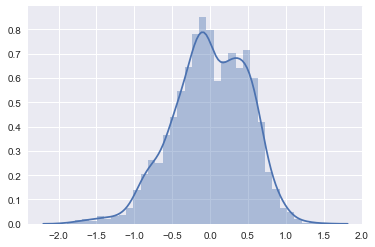

In [68]:
log_log_regression_evaluation(reg_df.spread_favorite, reg_df.exp_win_difference)

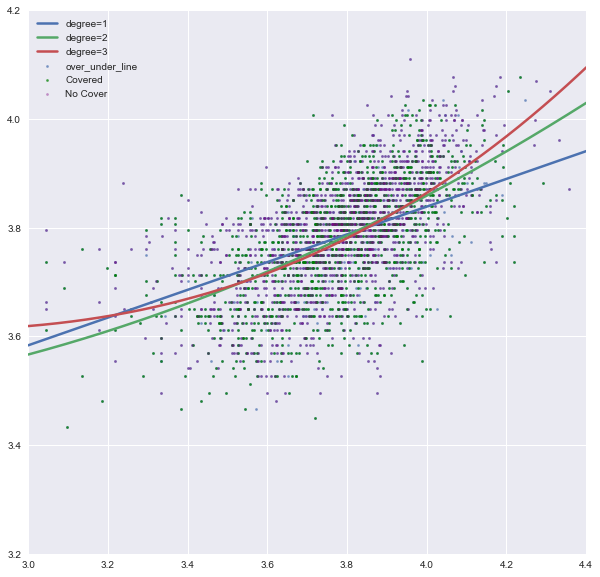

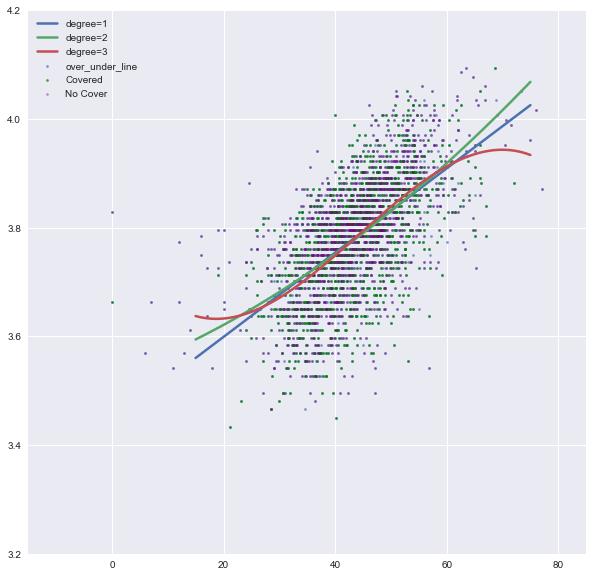

In [65]:
#poly_regression((reg_df.total_ppg), reg_df.over_under_line, [1,2],15,85, 25, 65,10,150)
log_log_regression(reg_df.total_ppg, reg_df.over_under_line, [1,2,3],3,4.4,3.2,4.2,0,5)
log_linear_regression(reg_df.total_ppg, reg_df.over_under_line, [1,2,3],-15,85,3.2,4.2,15,75)#log-linear reg, change logx to x in function

# Testing Predictions

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


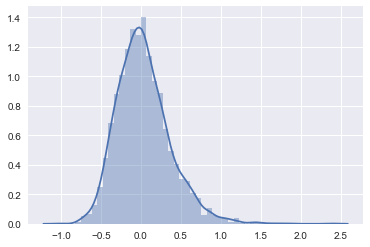

In [90]:
#log-log
y = .6648+.0326*np.log(week5_df.weather_temperature+1)-.0139*np.log(week5_df.weather_wind_mph+1)-.0118*np.log(week5_df.weather_humidity+1)+.4627*np.log(week5_df.total_ppg+1)+.3439*np.log(week5_df.total_points_against+1)
diff = y - np.log(week5_df.point_total+1)
sns.distplot(diff)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


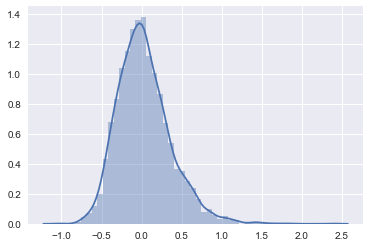

In [91]:
#log-linear
y = 3.0086+.0006*(week5_df.weather_temperature)-.0028*(week5_df.weather_wind_mph)-.0003*(week5_df.weather_humidity)+.0103*(week5_df.total_ppg)+.0074*(week5_df.total_points_against)
diff = y - np.log(week5_df.point_total+1)
sns.distplot(diff)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


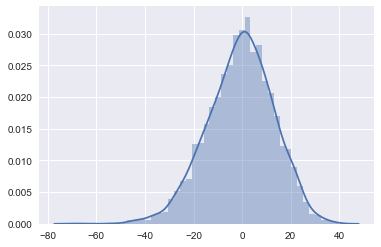

In [79]:
#linear
y = 8.5852+.0298*(week5_df.weather_temperature)-.113*(week5_df.weather_wind_mph)-.0103*(week5_df.weather_humidity)+.4529*(week5_df.total_ppg)+.3294*(week5_df.total_points_against)
diff = y - week5_df.point_total
sns.distplot(diff)

ou_df = week5_df[['over_under_line','over_under_result','point_total']]

In [80]:
y = 8.5852+.0298*(week5_df.weather_temperature)-.113*(week5_df.weather_wind_mph)-.0103*(week5_df.weather_humidity)+.4529*(week5_df.total_ppg)+.3294*(week5_df.total_points_against)
ou_df = week5_df[['over_under_line','over_under_result','point_total']]

ou_df['prediction']= y
ou_df['over_under_result'] = np.where(ou_df['over_under_result']=='over', 1, 0)

ou_df['good_prediction']=np.where((ou_df['prediction']<ou_df['over_under_line']) & (ou_df['over_under_result']==0),1,0)
ou_df['good_prediction']=np.where((ou_df['prediction']>ou_df['over_under_line']) & (ou_df['over_under_result']==1),1,ou_df['good_prediction'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [81]:
np.sum(ou_df.good_prediction)/len(ou_df)

0.5090032154340836

## Predict home and way point totals, from there we can derive spread and o/u

In [82]:
pd.set_option('display.max_columns', 1000)
week5_df.corr()

,schedule_season,schedule_week,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,weather_humidity,score_home,score_away,point_total,score_difference,home_favorite,favorite_covered,home_wins,home_losses,home_ties,away_wins,away_losses,away_ties,home_points_for,home_points_against,away_points_for,away_points_against,h_games,a_games,home_win_pct,away_win_pct,win_pct_diff,h_ppg,h_papg,a_ppg,a_papg,home_pt_diff_pg,away_pt_diff_pg,pt_diff_pg,home_exp_win_pct,away_exp_win_pct,home_win_pct_last_4,away_win_pct_last_4,exp_win_difference,total_ppg,total_points_against,last_four_difference
schedule_season,1.000000,-0.001999,0.014470,0.331189,0.113061,-0.222340,-0.068401,0.039526,0.056750,0.070170,-0.011471,-0.068842,-0.036980,0.007593,0.003046,0.038746,0.002516,0.006730,0.048256,0.077455,0.079802,0.077693,0.081646,0.009292,0.008514,0.000462,-0.000687,0.000817,0.140759,0.158937,0.141551,0.159303,-0.000111,0.000130,-0.000173,0.001820,0.002821,-0.000708,-0.005887,-0.000722,0.195429,0.216731,0.003711
schedule_week,-0.001999,1.000000,-0.087865,-0.044495,-0.350360,0.014006,0.078472,-0.010523,-0.036356,-0.034099,0.017564,-0.013050,-0.037197,0.637521,0.634086,0.055684,0.633268,0.638734,0.056540,0.848180,0.884070,0.847985,0.884624,0.995689,0.995664,0.006579,-0.016146,0.016157,0.014071,0.003746,0.006345,0.037700,0.007555,-0.019024,0.019090,-0.001600,-0.022643,0.058714,0.046722,0.015033,0.014115,0.028310,0.008483
spread_favorite,0.014470,-0.087865,1.000000,-0.027486,0.058545,-0.002069,0.012550,-0.127483,0.150094,0.015407,-0.190503,-0.180816,0.101509,-0.235556,0.124199,-0.018259,0.141718,-0.256463,0.016740,-0.193011,-0.001021,0.040597,-0.158215,-0.087787,-0.090265,-0.229482,0.264427,-0.351215,-0.226854,0.152066,0.224174,-0.182171,-0.254010,0.270790,-0.376378,-0.262649,0.280093,-0.188394,0.210939,-0.386522,-0.000853,-0.021333,-0.285677
over_under_line,0.331189,-0.044495,-0.027486,1.000000,0.200052,-0.293958,-0.060153,0.204085,0.200516,0.295186,0.003943,-0.059935,-0.073602,0.061377,-0.113090,-0.011009,0.077504,-0.128558,0.030552,0.205775,0.108034,0.202259,0.083786,-0.040586,-0.039625,0.113449,0.136888,-0.016589,0.476907,0.314137,0.472284,0.268349,0.139336,0.164326,-0.018703,0.133886,0.151444,0.100701,0.108494,-0.013078,0.657060,0.396574,-0.005763
weather_temperature,0.113061,-0.350360,0.058545,0.200052,1.000000,-0.412407,-0.049344,-0.001395,0.081567,0.058163,-0.056667,-0.039864,-0.005278,-0.285188,-0.157589,-0.067115,-0.227415,-0.212240,-0.041167,-0.302831,-0.240951,-0.282022,-0.292691,-0.347986,-0.344670,-0.083160,-0.004109,-0.056242,-0.021137,0.130597,0.023390,0.017319,-0.096176,0.005632,-0.072773,-0.091159,0.006171,-0.059127,-0.009876,-0.069138,0.001659,0.100453,-0.035168
weather_wind_mph,-0.222340,0.014006,-0.002069,-0.293958,-0.412407,1.000000,0.010351,-0.085605,-0.111780,-0.143897,0.017243,0.028833,0.004037,0.014824,0.003588,-0.003845,-0.000564,0.017581,-0.015456,-0.029633,-0.051007,-0.016277,-0.000861,0.014308,0.012937,0.010601,-0.013025,0.016800,-0.081852,-0.130357,-0.057832,-0.029991,0.023686,-0.021900,0.032685,0.013226,-0.024048,0.015261,-0.014758,0.026565,-0.096642,-0.108951,0.021473
weather_humidity,-0.068401,0.078472,0.012550,-0.060153,-0.049344,0.010351,1.000000,-0.008048,-0.007527,-0.011364,-0.000415,-0.016670,-0.002997,0.027820,0.073145,0.020731,0.054714,0.043153,0.006452,0.050215,0.064712,0.062391,0.064618,0.079433,0.076630,-0.034114,0.018366,-0.037324,-0.037031,-0.011840,0.006690,-0.013405,-0.018630,0.013060,-0.022710,-0.017950,0.012035,-0.014375,0.015462,-0.021340,-0.020906,-0.017197,-0.021345
score_home,0.039526,-0.010523,-0.127483,0.204085,-0.001395,-0.085605,-0.008048,1.000000,-0.060579,0.689501,0.731667,0.215824,0.188181,0.160061,-0.172340,0.009657,-0.084506,0.074680,0.001498,0.134044,-0.050007,-0.024710,0.053854,-0.009122,-0.007229,0.205545,-0.096077,0.214523,0.267852,-0.092056,-0.026903,0.120858,0.245454,-0.094144,0.243136,0.242847,-0.104899,0.173021,-0.081051,0.247352,0.166139,0.020144,0.181663
score_away,0.

                            OLS Regression Results                            
Dep. Variable:             score_home   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     21.87
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           3.51e-38
Time:                        11:05:53   Log-Likelihood:                -4983.0
No. Observations:                1352   AIC:                             9988.
Df Residuals:                    1341   BIC:                         1.005e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.6861    

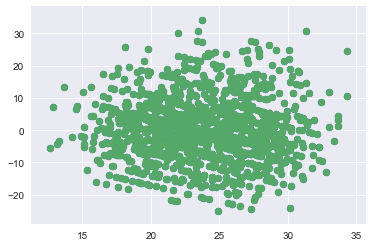

In [86]:
regression_evaluation(test_df.score_home,test_df[['spread_favorite','over_under_line','weather_wind_mph',
                                                  'home_favorite','h_ppg','a_papg','home_exp_win_pct',
                                                 'away_exp_win_pct','home_win_pct_last_4','away_win_pct_last_4']])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


7.375

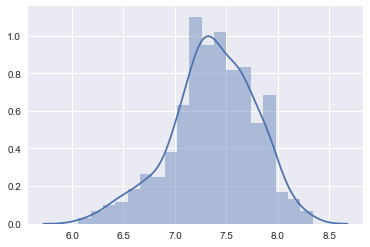

In [69]:
t = [9,9,9,9,9,9,1,4]
sns.distplot(n_samples(t,50,500))
np.sum(t)/len(t)

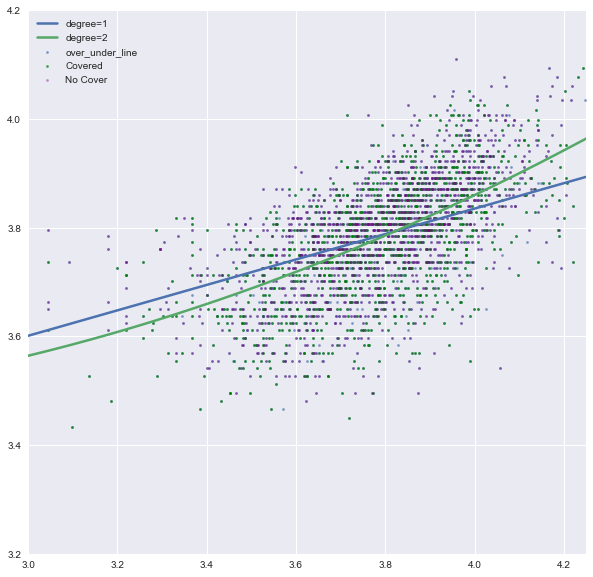

In [74]:
log_log_regression(reg_df.total_ppg,reg_df.over_under_line,[1,2],3,4.25,3.2,4.2,0,5)

In [83]:
def test_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
    
    split = train_test_split(x, y,test_size = 0.25, random_state = 42)
    print(split[0].features)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)
    
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [70]:
test_df = reg_df[(reg_df.schedule_week>4)]
test_df[test_df.weather_detail=='DOME']
test_df['dome'] = np.where(test_df['weather_detail']=='DOME', 1, 0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
def log_log_regression_evaluation(target, X_list):
    split = train_test_split((np.log(np.abs(X_list)+1)), np.log(np.abs(target)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

In [67]:
def log_linear_regression_evaluation(target,X_list):
    split = train_test_split(X_list, np.log(np.abs(target)+1))## log-linear eval
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))